Для набора данных blood_cells.

( вариант 2 использовать оригинальные данные)

Решите задачу сегментации  и подсчет количества клеток.

Алгоритм 1. Метод Хафа для поиска окружностей.

Алгоритм 2. Алгоритм водораздел+карта расстояний для сегментации пересекающихся объектов.

Показатели качества решения задачи сегментации: accuracy, precision. Усреднить по количеству изображений теста.

min количество изобаржений для тестирования - 10.


Изображение 1:
Метод Хафа - Обнаружено клеток: 0
Алгоритм водораздела - Обнаружено клеток: 26


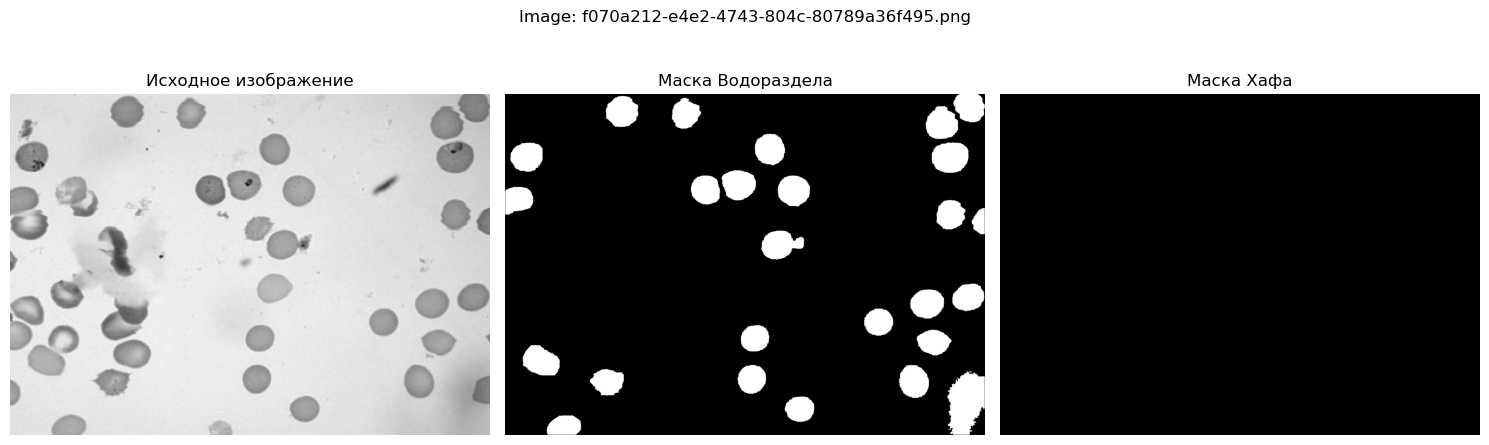


Изображение 2:
Метод Хафа - Обнаружено клеток: 38
Алгоритм водораздела - Обнаружено клеток: 54


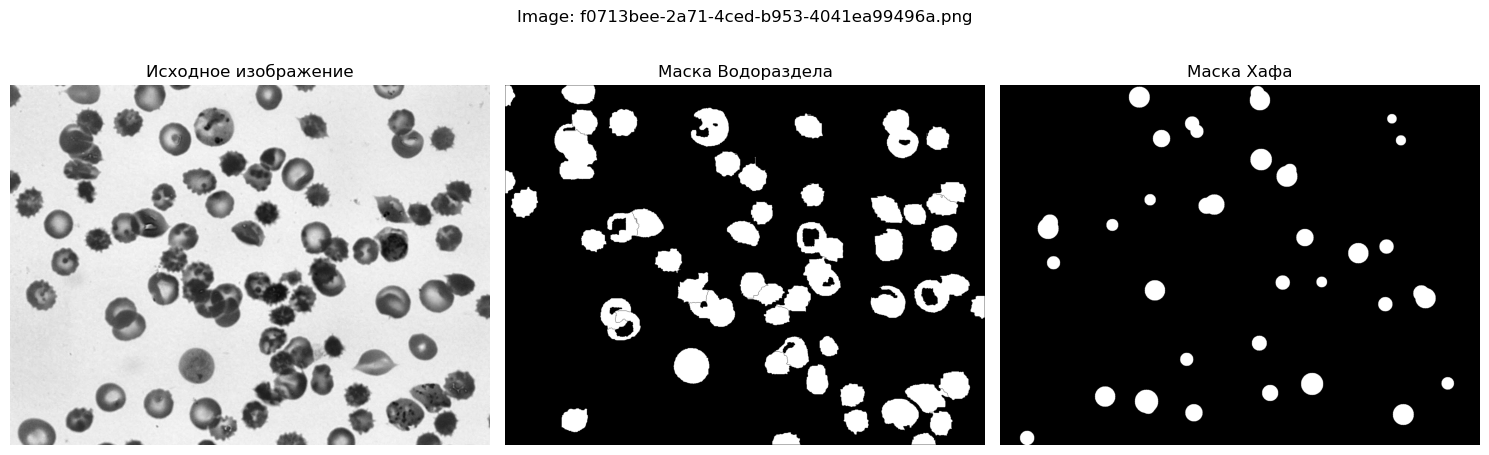


Изображение 3:
Метод Хафа - Обнаружено клеток: 53
Алгоритм водораздела - Обнаружено клеток: 6


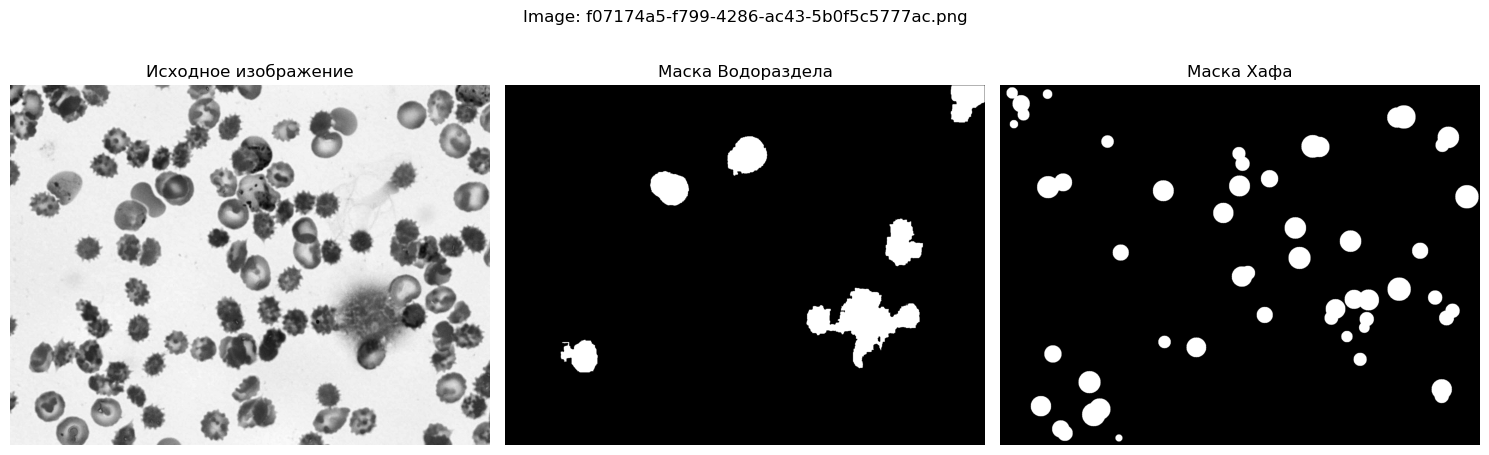


Изображение 4:
Метод Хафа - Обнаружено клеток: 43
Алгоритм водораздела - Обнаружено клеток: 55


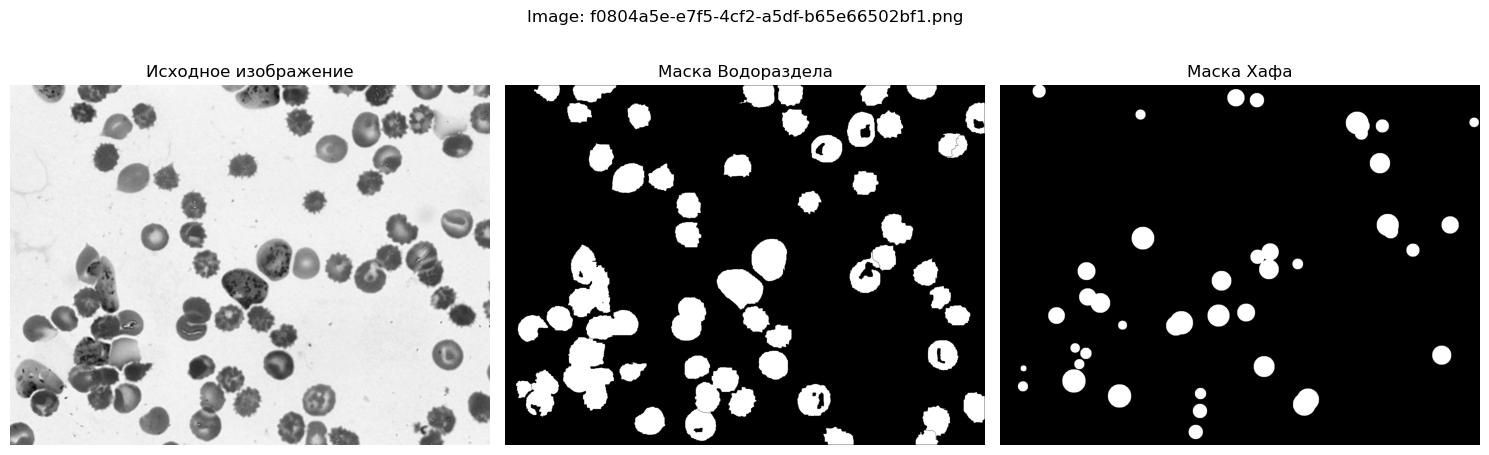


Изображение 5:
Метод Хафа - Обнаружено клеток: 11
Алгоритм водораздела - Обнаружено клеток: 61


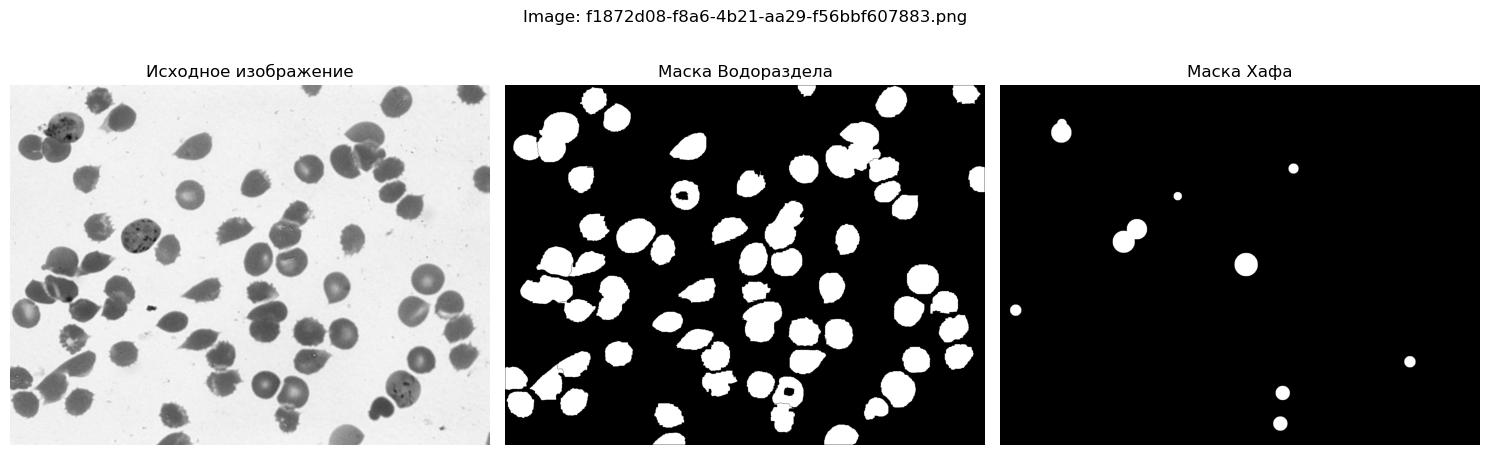


Изображение 6:
Метод Хафа - Обнаружено клеток: 105
Алгоритм водораздела - Обнаружено клеток: 16


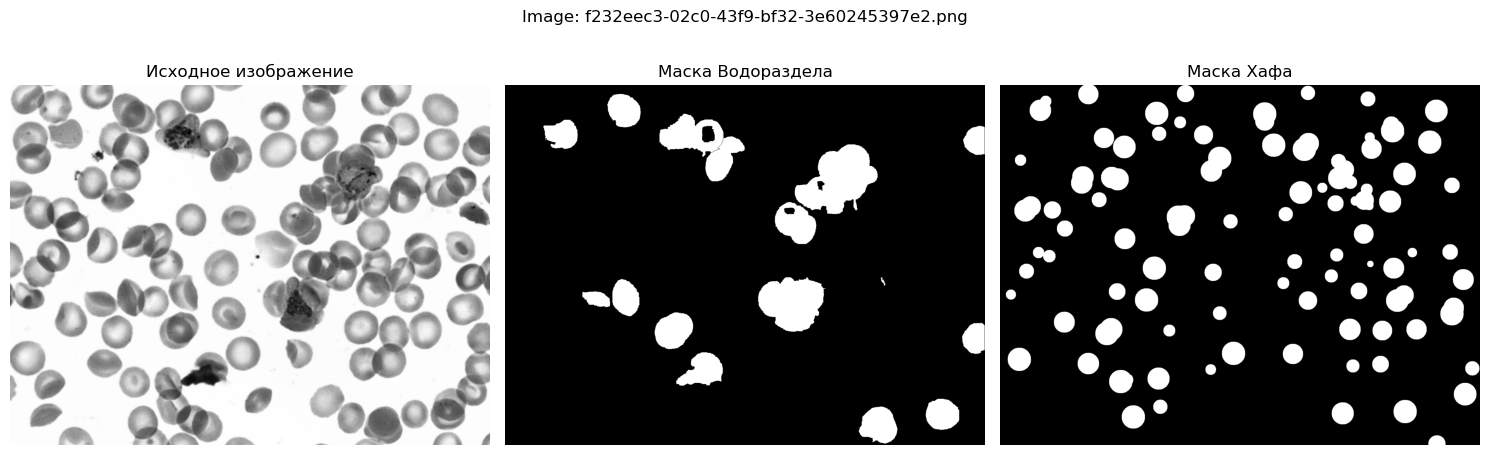


Изображение 7:
Метод Хафа - Обнаружено клеток: 20
Алгоритм водораздела - Обнаружено клеток: 78


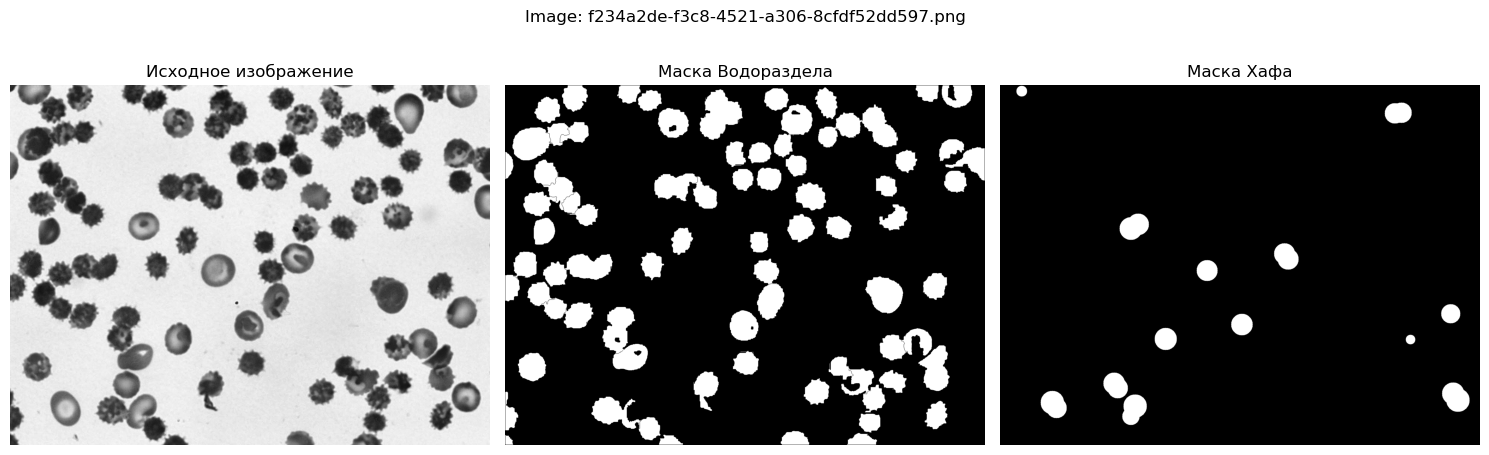


Изображение 8:
Метод Хафа - Обнаружено клеток: 15
Алгоритм водораздела - Обнаружено клеток: 42


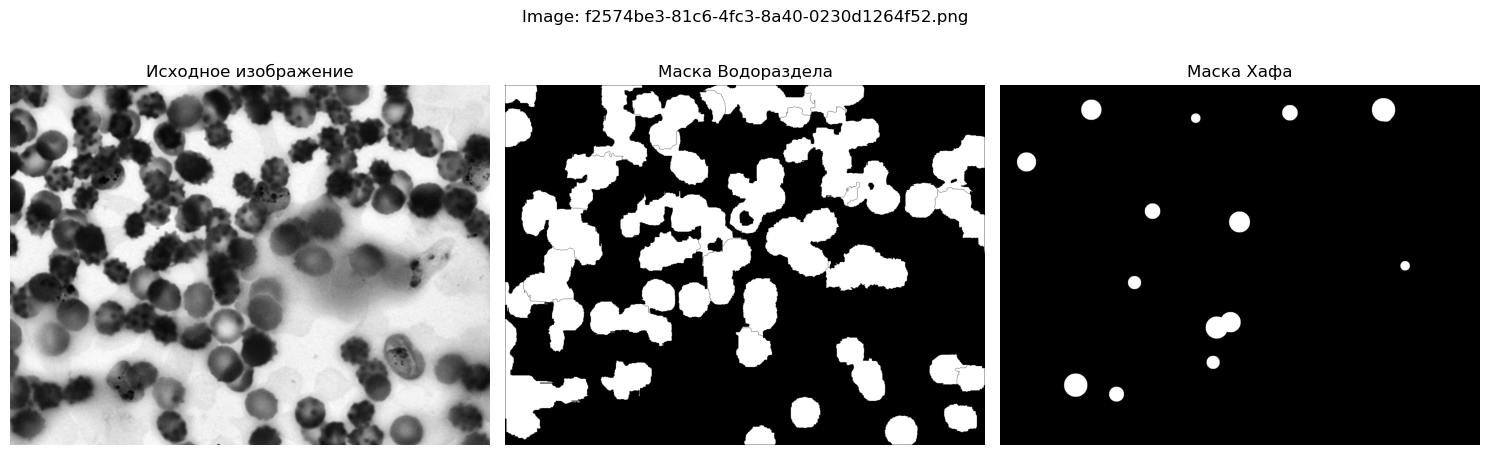


Изображение 9:
Метод Хафа - Обнаружено клеток: 66
Алгоритм водораздела - Обнаружено клеток: 112


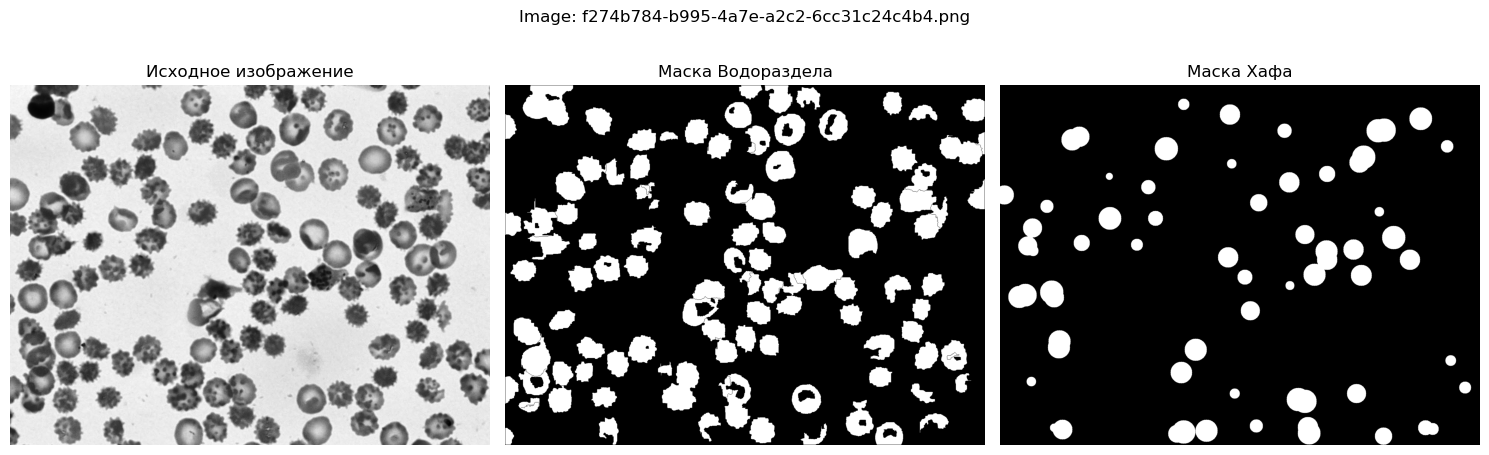


Изображение 10:
Метод Хафа - Обнаружено клеток: 7
Алгоритм водораздела - Обнаружено клеток: 28


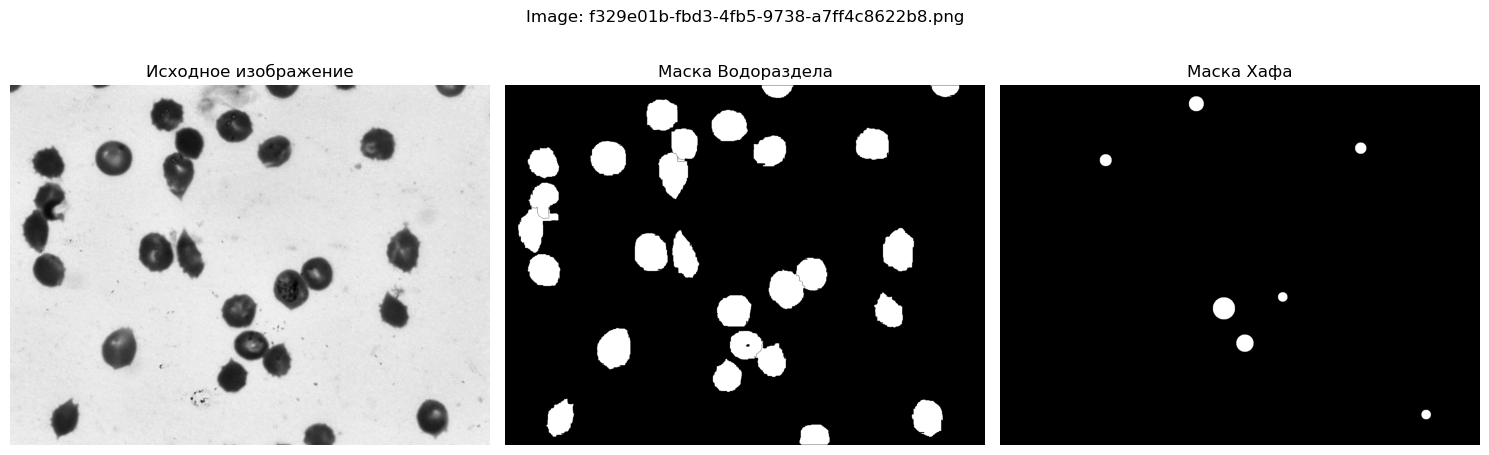


Изображение 11:
Метод Хафа - Обнаружено клеток: 123
Алгоритм водораздела - Обнаружено клеток: 18


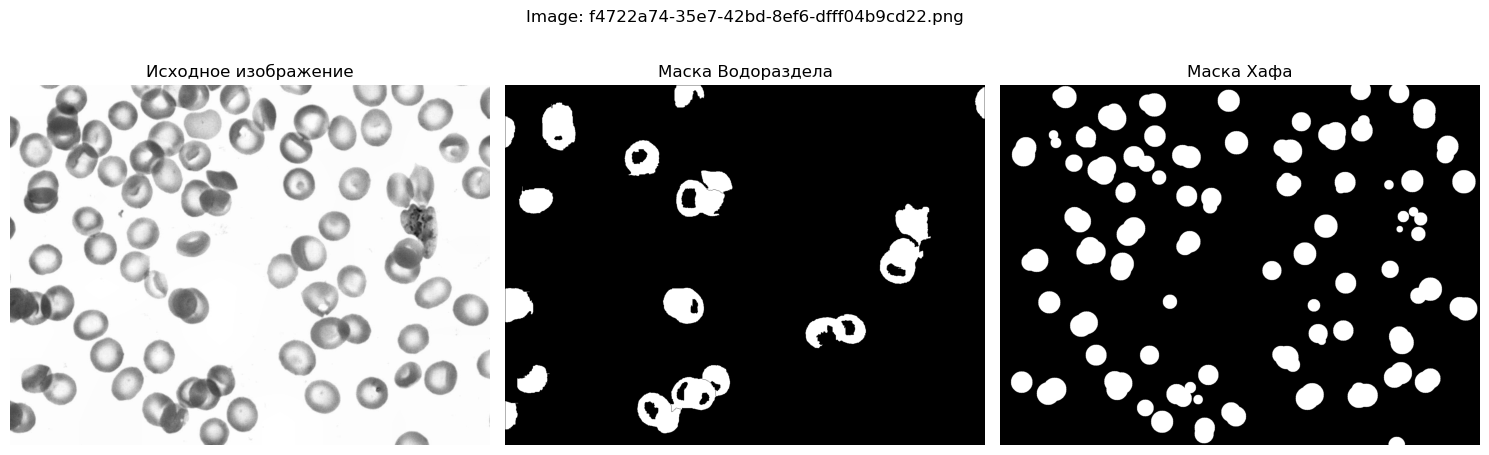


Изображение 12:
Метод Хафа - Обнаружено клеток: 3
Алгоритм водораздела - Обнаружено клеток: 32


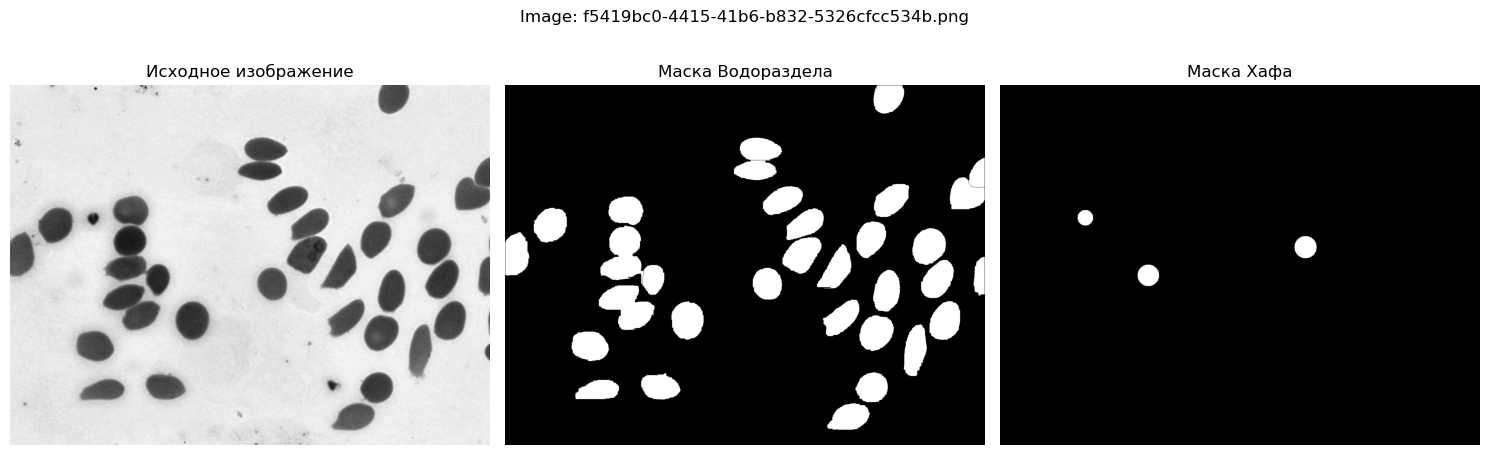


Изображение 13:
Метод Хафа - Обнаружено клеток: 28
Алгоритм водораздела - Обнаружено клеток: 58


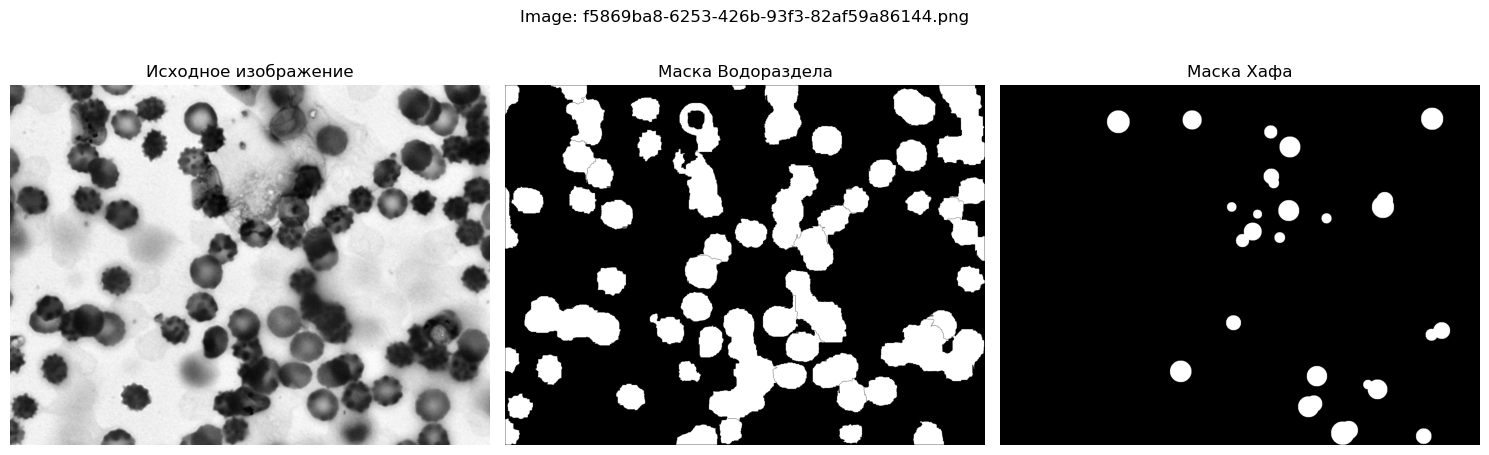


Изображение 14:
Метод Хафа - Обнаружено клеток: 12
Алгоритм водораздела - Обнаружено клеток: 43


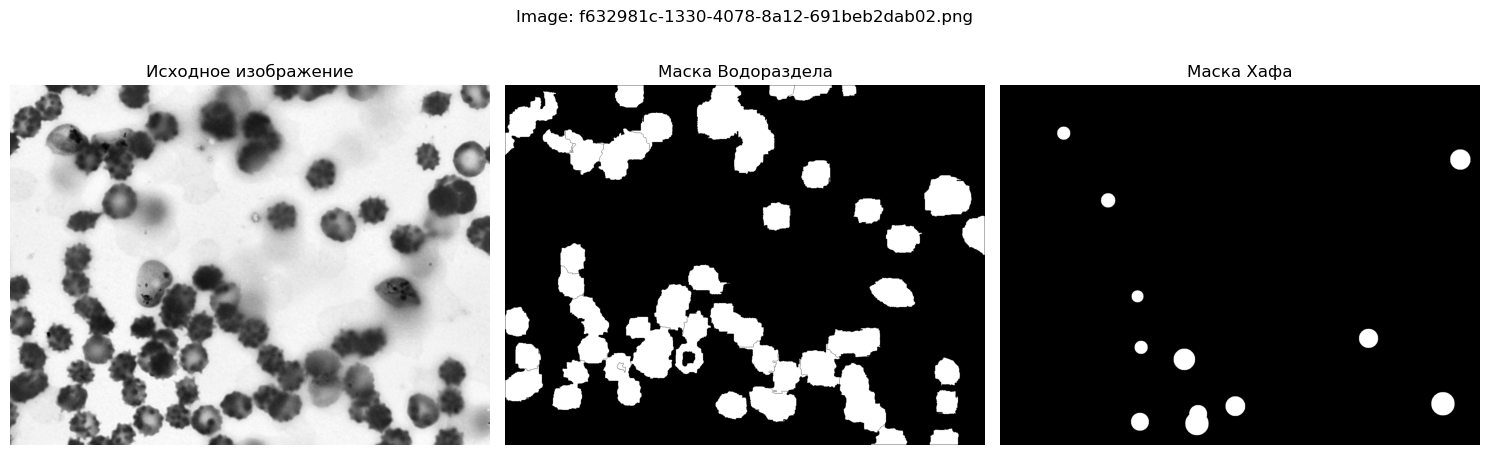


Изображение 15:
Метод Хафа - Обнаружено клеток: 1
Алгоритм водораздела - Обнаружено клеток: 32


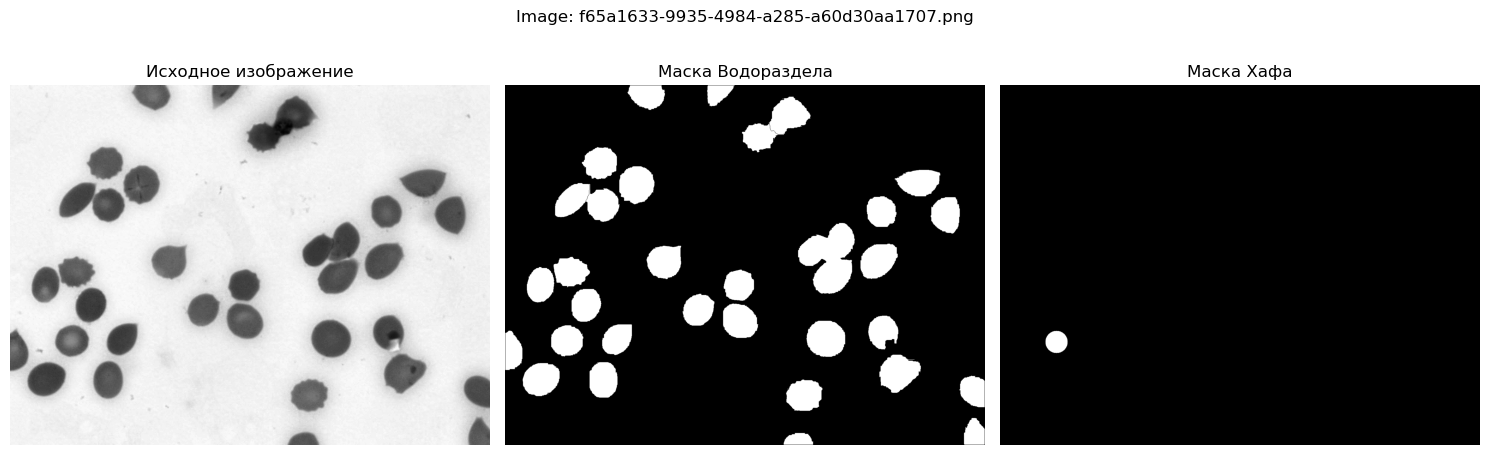


Изображение 16:
Метод Хафа - Обнаружено клеток: 29
Алгоритм водораздела - Обнаружено клеток: 62


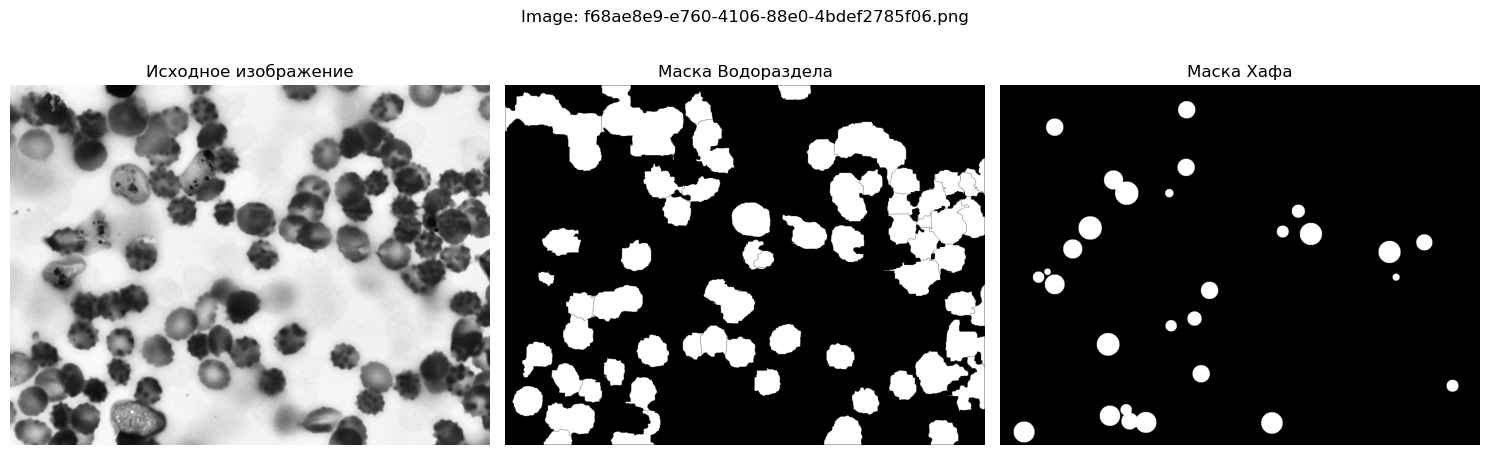


Изображение 17:
Метод Хафа - Обнаружено клеток: 21
Алгоритм водораздела - Обнаружено клеток: 21


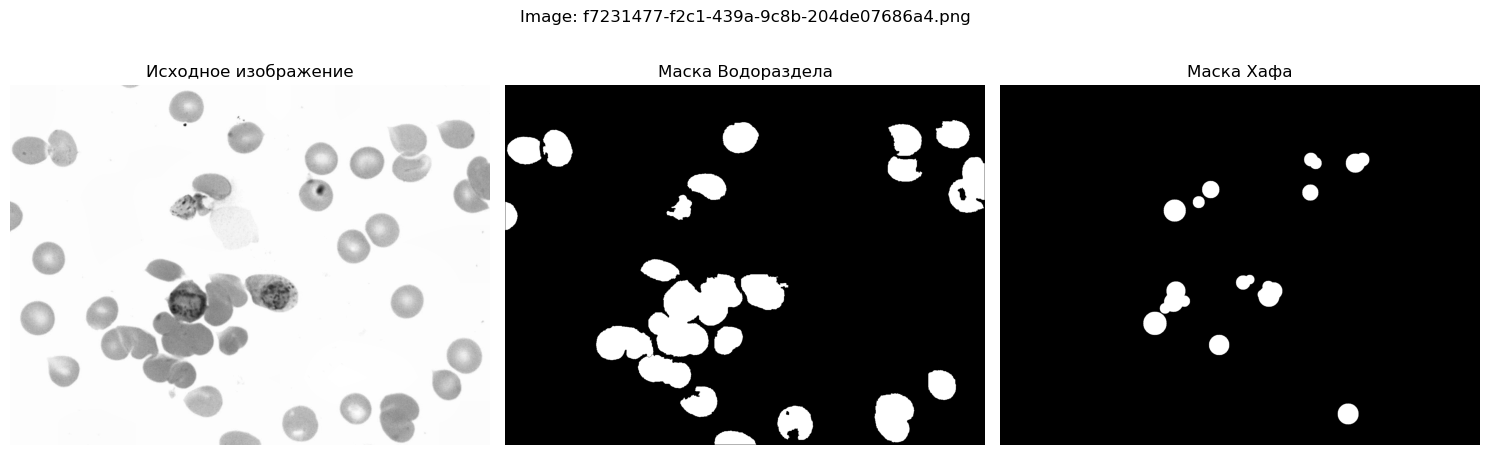


Изображение 18:
Метод Хафа - Обнаружено клеток: 38
Алгоритм водораздела - Обнаружено клеток: 70


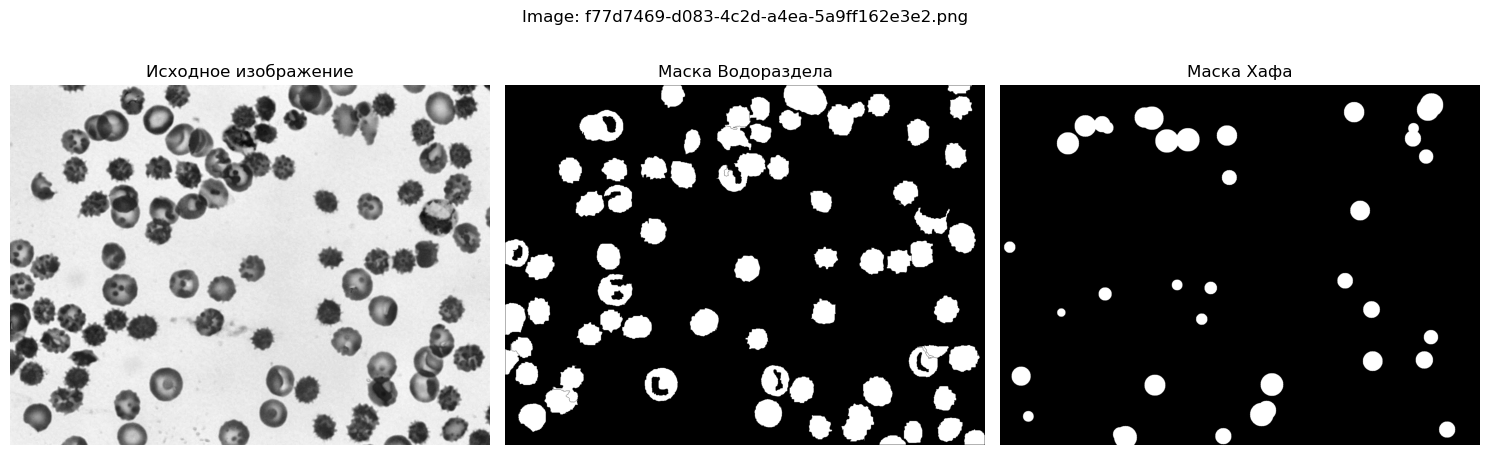


Изображение 19:
Метод Хафа - Обнаружено клеток: 6
Алгоритм водораздела - Обнаружено клеток: 31


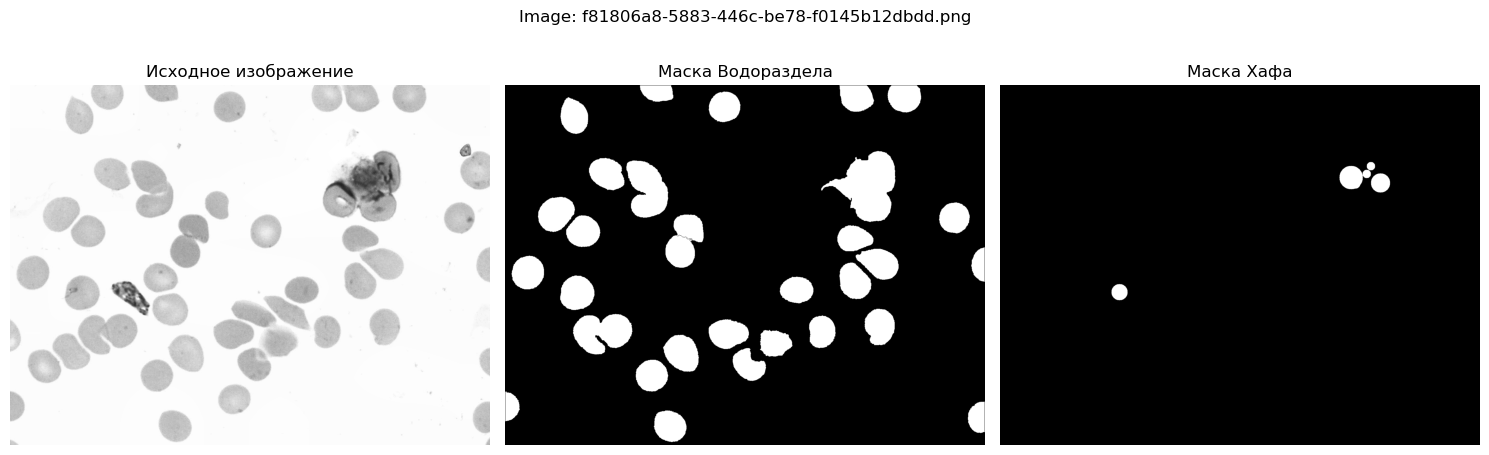


Изображение 20:
Метод Хафа - Обнаружено клеток: 5
Алгоритм водораздела - Обнаружено клеток: 26


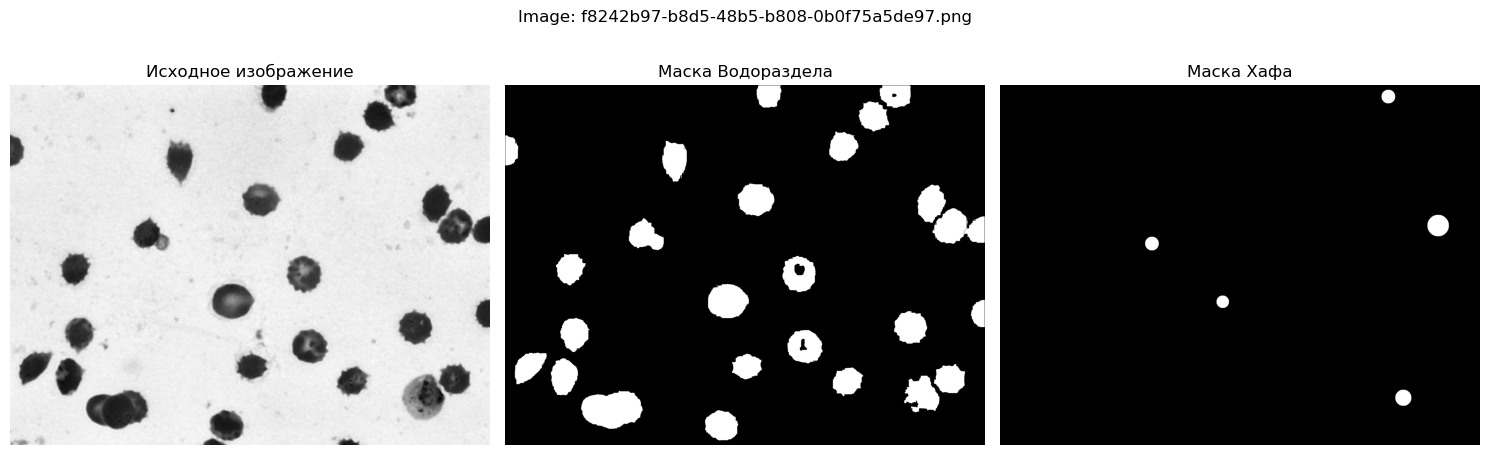


Results:
Watershed Segmentation:
  Average Accuracy: 0.8737
  Average Precision: 0.9751

Hough Circle Detection:
  Average Accuracy: 0.7435
  Average Precision: 0.9025


In [19]:
import cv2
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score
from glob import glob
import matplotlib.pyplot as plt  # Import matplotlib

def watershed_segmentation(image_path, threshold_method=cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU, param=0.7):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    thresh = cv2.threshold(img, 0, 255, threshold_method)[1]
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)
    dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, param * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(closing, kernel, iterations=3)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers) 
    binary_mask = np.zeros_like(markers, dtype=np.uint8)
    binary_mask[markers > 1] = 255
    num_cells = len(np.unique(markers)) - 2  
    return binary_mask, img, num_cells, markers

def calculate_metrics(ground_truth_mask, predicted_mask):
    gt_flat = ground_truth_mask.flatten()
    pred_flat = predicted_mask.flatten()
    accuracy = accuracy_score(gt_flat, pred_flat)
    precision = precision_score(gt_flat, pred_flat, zero_division=0)
    return accuracy, precision

def evaluate_segmentation(image_path, mask_path):
    ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255
    predicted_mask, img, watershed_cells_count, markers = watershed_segmentation(image_path, param=0.5)
    accuracy, precision = calculate_metrics(ground_truth_mask, predicted_mask / 255)
    return accuracy, precision, predicted_mask, img, watershed_cells_count, markers

def hough_circle_segmentation(image_path, param1=50, param2=30, min_radius=15, max_radius=35):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 20,
                                param1=param1, param2=param2,
                                minRadius=min_radius, maxRadius=max_radius)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        hough_mask = np.zeros_like(img, dtype=np.uint8)
        for i in circles[0, :]:
            center_x, center_y, radius = i
            cv2.circle(hough_mask, (center_x, center_y), radius, 255, -1) 
        return hough_mask, len(circles[0, :])
    else:
        return np.zeros_like(img, dtype=np.uint8), 0

image_dir = "blood_cells_dataset/original"
mask_dir = "blood_cells_dataset/mask"
image_paths = sorted(glob(os.path.join(image_dir, "*.png")))
mask_paths = [path.replace("original", "mask") for path in image_paths]
test_images = list(zip(image_paths, mask_paths))[:20]
watershed_accuracies = []
watershed_precisions = []
hough_accuracies = []
hough_precisions = []
num_cells = []
hough_cells_counts = []

for i, (image_path, mask_path) in enumerate(test_images):
    accuracy, precision, predicted_mask, img, watershed_cells_count, markers = evaluate_segmentation(image_path, mask_path)
    hough_mask, hough_cells_count = hough_circle_segmentation(image_path, param1=40, param2=27, min_radius=10, max_radius=40)
    if predicted_mask is not None and hough_mask is not None:
        hough_accuracy, hough_precision = calculate_metrics(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255, hough_mask / 255)
        hough_accuracies.append(hough_accuracy)
        hough_precisions.append(hough_precision)
    if accuracy is not None and precision is not None and markers is not None and img is not None and predicted_mask is not None and hough_mask is not None:
        watershed_accuracies.append(accuracy)
        watershed_precisions.append(precision)
        num_cells.append(watershed_cells_count)
        hough_cells_counts.append(hough_cells_count)
        print(f"\nИзображение {i + 1}:")
        print(f"Метод Хафа - Обнаружено клеток: {hough_cells_count}")
        print(f"Алгоритм водораздела - Обнаружено клеток: {watershed_cells_count}")
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f"Image: {os.path.basename(image_path)}")
        original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        axes[0].imshow(original_img, cmap='gray') 
        axes[0].set_title("Исходное изображение")
        axes[0].axis('off')
        axes[1].imshow(predicted_mask, cmap='gray') 
        axes[1].set_title("Маска Водораздела")
        axes[1].axis('off')
        axes[2].imshow(hough_mask, cmap='gray') 
        axes[2].set_title("Маска Хафа")
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()



print("\nResults:")
print("Watershed Segmentation:")
print(f"  Average Accuracy: {np.mean(watershed_accuracies):.4f}")
print(f"  Average Precision: {np.mean(watershed_precisions):.4f}")

print("\nHough Circle Detection:")
print(f"  Average Accuracy: {np.mean(hough_accuracies):.4f}")
print(f"  Average Precision: {np.mean(hough_precisions):.4f}")